In [1]:
import os
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler


from django_pandas.io import read_frame
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "dashboard.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import django
django.setup()
from home.models import NTDdata



In [2]:
qs = NTDdata.objects.all()
df = read_frame(qs)
df['Date'] = pd.to_datetime(df["Date"])

df['month'] = pd.DatetimeIndex(
        pd.to_datetime(df['Date'], format='%b')).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'], format='%Y')).year
df.set_index('Date')


,id,High,Low,Close,month,year
Date,,,,,,
1996-11-18,1,1.800,1.7250,1.8000,11,1996
1996-11-19,2,1.800,1.7250,1.8000,11,1996
1996-11-20,3,1.850,1.7000,1.8125,11,1996
1996-11-21,4,1.825,1.7125,1.8000,11,1996
1996-11-22,5,1.850,1.7500,1.8250,11,1996
...,...,...,...,...,...,...
2023-11-07,6788,11.000,10.6700,10.9800,11,2023
2023-11-08,6789,11.540,11.3000,11.3600,11,2023
2023-11-09,6790,11.870,11.6700,11.6800,11,2023


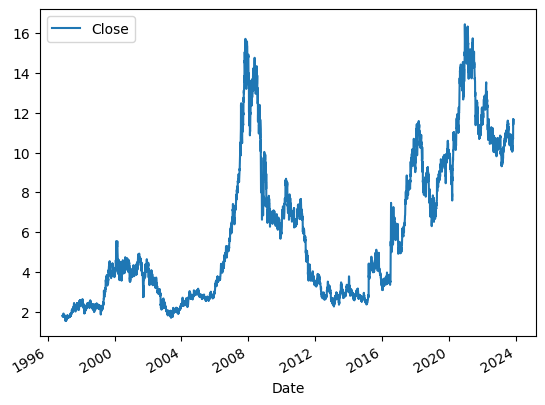

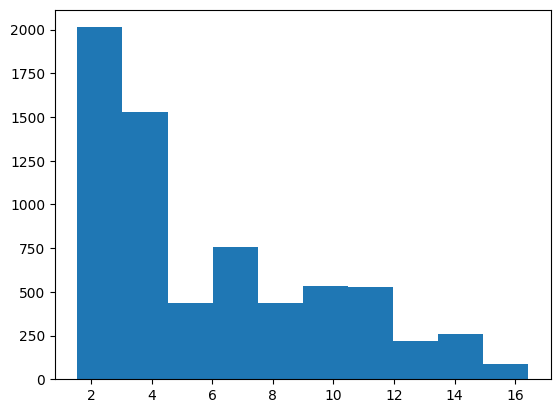

In [71]:
import matplotlib.pyplot as plt
data = df[['Date', 'Close']]
data =  data.set_index('Date')
data = data.sort_index()
data.plot()
plt.show()
plt.hist(data['Close'])
plt.show()

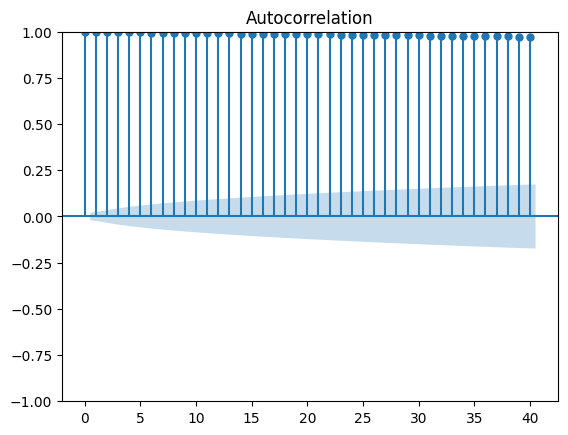

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data["Close"])
plt.show()

The ACF plot shows a gradual decline indication that our data is non-stationary.

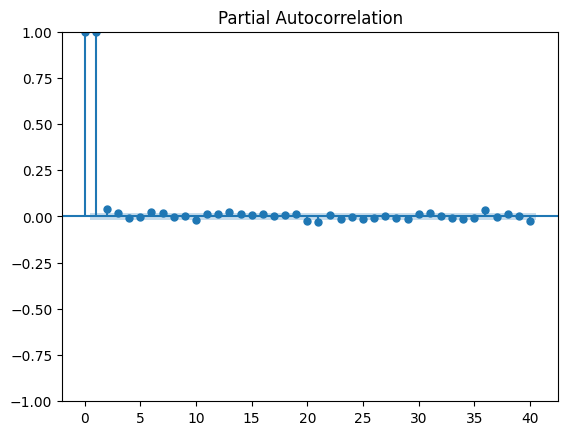

In [69]:
plot_pacf(data["Close"])
plt.show()

Our PACF plot has a significant spike at the beginnig, which suggests an autoregressive term of order 1.

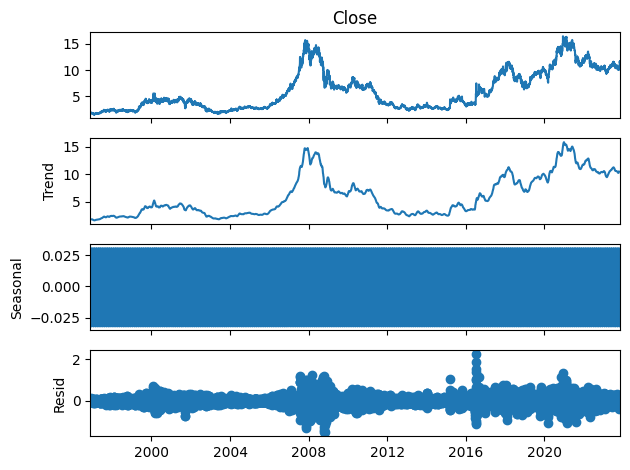

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Close'], model="additive", period=24)
decomposition.plot()
plt.show()

In [76]:
df_gam = pd.DataFrame()
df_gam['time'] = np.arange(len(data))
df_gam['month'] = data.index.month

In [77]:
df_gam['month_sin'] = np.sin(2 * np.pi * df_gam['month'] / 12)
df_gam['month_cos'] = np.cos(2 * np.pi * df_gam['month'] / 12)

In [78]:
from pygam import GAM, s

gam = GAM(s(0) + s(1) + s(2))

In [79]:
train_size = int(0.8 * len(df_gam))

X_train = df_gam.iloc[:train_size].values
X_test = df_gam.iloc[train_size:].values

y_train = data.iloc[:train_size].values
y_test = data.iloc[train_size:].values


In [80]:
gam.fit(X_train, y_train)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [5]:
from prophet import Prophet

data= df[['Date', 'Close']]
data=data.rename(columns={'Date': 'ds', 'Close': 'y'})
m = Prophet()

m.fit(data)



10:02:52 - cmdstanpy - INFO - Chain [1] start processing
10:02:54 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = m.make_future_dataframe(periods=365)
future.tail()
import json

forecast = m.predict(future)
futuredata=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [29]:
test=futuredata.to_json(orient='records')
print(test)

[{"ds":1731024000000,"yhat":12.5390880577,"yhat_lower":10.8599024715,"yhat_upper":14.185204016},{"ds":1731110400000,"yhat":12.6755438411,"yhat_lower":10.9632506125,"yhat_upper":14.3159397902},{"ds":1731196800000,"yhat":12.6785401244,"yhat_lower":10.9117008246,"yhat_upper":14.4080057425},{"ds":1731283200000,"yhat":12.5591019261,"yhat_lower":10.9077729603,"yhat_upper":14.363372301},{"ds":1731369600000,"yhat":12.5665995534,"yhat_lower":10.8844268448,"yhat_upper":14.3339648787}]


In [10]:

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days')


  0%|          | 0/25 [00:00<?, ?it/s]

10:26:12 - cmdstanpy - INFO - Chain [1] start processing
10:26:12 - cmdstanpy - INFO - Chain [1] done processing
10:26:12 - cmdstanpy - INFO - Chain [1] start processing
10:26:13 - cmdstanpy - INFO - Chain [1] done processing
10:26:13 - cmdstanpy - INFO - Chain [1] start processing
10:26:13 - cmdstanpy - INFO - Chain [1] done processing
10:26:13 - cmdstanpy - INFO - Chain [1] start processing
10:26:13 - cmdstanpy - INFO - Chain [1] done processing
10:26:13 - cmdstanpy - INFO - Chain [1] start processing
10:26:14 - cmdstanpy - INFO - Chain [1] done processing
10:26:14 - cmdstanpy - INFO - Chain [1] start processing
10:26:14 - cmdstanpy - INFO - Chain [1] done processing
10:26:15 - cmdstanpy - INFO - Chain [1] start processing
10:26:15 - cmdstanpy - INFO - Chain [1] done processing
10:26:15 - cmdstanpy - INFO - Chain [1] start processing
10:26:16 - cmdstanpy - INFO - Chain [1] done processing
10:26:16 - cmdstanpy - INFO - Chain [1] start processing
10:26:16 - cmdstanpy - INFO - Chain [1]

In [11]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

10:27:56 - cmdstanpy - INFO - Chain [1] start processing
10:27:57 - cmdstanpy - INFO - Chain [1] done processing
10:27:58 - cmdstanpy - INFO - Chain [1] start processing
10:27:59 - cmdstanpy - INFO - Chain [1] done processing
10:27:59 - cmdstanpy - INFO - Chain [1] start processing
10:28:01 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days,4.411868,2.100445,1.485138,0.226820,0.217072,0.227605,0.327838
1,39 days,4.348793,2.085376,1.474906,0.225190,0.212794,0.226766,0.330836
2,40 days,4.361633,2.088452,1.476791,0.223957,0.210445,0.225295,0.331210
3,41 days,4.308834,2.075773,1.470474,0.223663,0.211360,0.225771,0.329264
4,42 days,4.250203,2.061602,1.466024,0.224220,0.211360,0.226889,0.326527
